# Estimating grid cell fire frequencies

Authors: Jatan Buch (v1, 220207) || (v2, 220216) || (v3, 220228) || (v4, 220322) || (v5, 220414)

## 1 - Packages

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
#from time import clock
from datetime import date, datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm
from copy import deepcopy

#Import and write files
import csv
import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *

#Helper functions
from math import factorial
from scipy import stats
from scipy.special import gamma
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from tensorflow.python import ops
from tensorflow.python import debug as tf_debug

#Plot modules
import matplotlib.pyplot as plt
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

#Stats modules
from scipy import stats
from scipy.stats import norm, pareto, genpareto
import statsmodels.api as sm
from scipy import stats, interpolate
from scipy.optimize import minimize

# Data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, SplineTransformer
from sklearn.model_selection import train_test_split
import joblib

#modules for Machine Learning
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline

#modules for Neural Network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
#from tensorflow.keras import layers
#from tensorflow.python.ops.parallel_for.gradients import jacobian

In [2]:
data_dir= "../data/"
clim_df= pd.read_hdf('../data/clim_fire_freq_12km_data.h5')
clim_df.loc[clim_df[clim_df.fire_freq > 1].index, 'fire_freq']= np.ones(len(clim_df[clim_df.fire_freq > 1].index), dtype= np.int64) #sets all non-zero frequencies to 1
#clim_df= clim_df[clim_df.reg_indx != 0].reset_index().drop(columns= ['index'])

In [3]:
n_features= 36
start_month= 372
tot_test_months= 60
end_month= start_month + tot_test_months
rseed= np.random.randint(1000)

fire_freq_test_df= clim_df[(clim_df.month >= start_month) & (clim_df.month < end_month)]
fire_freq_train_ur_df= clim_df.drop(fire_freq_test_df.index)
    
tmp_freq_df= clim_df[clim_df.iloc[:, 0:n_features].columns] 
X_freq_ur_df= pd.DataFrame({})
scaler= StandardScaler().fit(fire_freq_train_ur_df.iloc[:, 0:n_features])
X_freq_ur_df[tmp_freq_df.columns]= scaler.transform(tmp_freq_df)

In [5]:
X_train_tot= X_freq_ur_df.iloc[fire_freq_train_ur_df.index]
X_train_tot.loc[:, 'reg_indx']= fire_freq_train_ur_df.reg_indx
X_train_tot.loc[:, 'month']= fire_freq_train_ur_df.month
X_train_tot= X_train_tot.reset_index().drop(columns=['index', 'Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'FFWI_max7', 'Avgprec_4mo', 'Avgprec_2mo', \
                                                                    'AvgVPD_4mo', 'AvgVPD_2mo', 'Tmax_max7', 'VPD_max7', 'Tmin_max7'])

X_test_ur_df= X_freq_ur_df.iloc[fire_freq_test_df.index]
X_test_ur_df.loc[:, 'reg_indx']= fire_freq_test_df.reg_indx
X_test_ur_df.loc[:, 'month']= fire_freq_test_df.month
X_test_ur_df= X_test_ur_df.reset_index().drop(columns=['index', 'Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'FFWI_max7', 'Avgprec_4mo', \
                                                                    'Avgprec_2mo', 'AvgVPD_4mo', 'AvgVPD_2mo', 'Tmax_max7', 'VPD_max7', 'Tmin_max7'])

X_test_tot= pd.concat([X_train_tot, X_test_ur_df], sort= False).reset_index().drop(columns=['index'])
fire_freq_tot= pd.concat([fire_freq_train_ur_df, fire_freq_test_df], sort= False).reset_index().drop(columns=['index'])

## MDN grid scale frequency 

### Upsampled model training and prediction

In [9]:
run_id= '03_02_22'
# hp_df= ml_fire_freq_hyperparam_tuning(clim_df, negfrac= 0.3, n_iters= 10, bs_arr= [8192], pfrac_arr= [0.3], start_month= 372, ml_model= 'mdn', run_id= run_id)
# hp_df.to_hdf('../sav_files/grid_freq_runs_%s'%run_id + '/grid_freq_hyperparams.h5', key= 'df', mode= 'w')
hp_df= pd.read_hdf('../sav_files/grid_freq_runs_%s'%run_id + '/grid_freq_hyperparams.h5')

In [10]:
hp_df

,Iteration,Batch size,Fire fraction,Epochs,Val Accuracy/Recall
0,1,8192,0.3,66,74.786311
1,2,8192,0.3,62,68.951550
2,3,8192,0.3,30,77.662445
3,4,8192,0.3,59,65.408513
4,5,8192,0.3,127,66.595397
5,6,8192,0.3,59,72.316809
6,7,8192,0.3,23,73.814933
7,8,8192,0.3,111,70.823376
8,9,8192,0.3,108,64.850535
9,10,8192,0.3,36,59.260847


In [ ]:
it, bs, p_frac= [1, 8192, '0.3']
mdn_grid_zipd= tf.keras.models.load_model('../sav_files/grid_freq_runs_%s'%run_id + '/mdn_%s'%bs + '_pfrac_%s'%p_frac + '_iter_run_%d'%it, \
                                                                                            custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
%time mdn_freq_df, rfac_arr= grid_freq_predict(X_test_dat= X_test_tot, freq_test_df= fire_freq_tot, n_regs= 18, ml_model= mdn_grid_zipd, start_month= 0, func_flag= 'zipd')
mdn_freq_groups= mdn_freq_df.groupby('reg_indx')
mdn_freq_df.to_hdf('../sav_files/fire_freq_pred_dfs/mdn_mon_fire_freq_%s'%run_id + 'it_%d'%it + '_%d_'%bs + '%s.h5'%str(pfrac), key= 'df', mode= 'w')

2022-04-14 16:40:23.882864: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### Downsampled model training and prediction

In [ ]:
loro_ind= None
if loro_ind != None:
    fire_freq_train_df= fire_freq_train_ur_df[fire_freq_train_ur_df != loro_ind].copy()
else:
    fire_freq_train_df= fire_freq_train_ur_df.copy()
    
tmp_freq_df= clim_df[clim_df.iloc[:, 0:n_features].columns] 
X_freq_df= pd.DataFrame({})
scaler= StandardScaler().fit(fire_freq_train_df.iloc[:, 0:n_features])
X_freq_df[tmp_freq_df.columns]= scaler.transform(tmp_freq_df)

In [4]:
rb_frac= 7/3 #fraction of no fires to fires
df1= fire_freq_train_df[fire_freq_train_df['fire_freq']==1]
n2= rb_frac*len(df1)
df2= fire_freq_train_df[fire_freq_train_df['fire_freq']==0]
df2= df2.sample(n= int(n2), random_state= rseed)
df_r= pd.concat([df1, df2], sort= False) #.sample(frac= 1).reset_index(drop=True) #shuffling the rows

X_train_df= X_freq_df.iloc[df_r.index].reset_index().drop(columns=['index', 'Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'FFWI_max7', 'Avgprec_4mo', 'Avgprec_2mo', \
                                                                    'AvgVPD_4mo', 'AvgVPD_2mo', 'Tmax_max7', 'VPD_max7', 'Tmin_max7'])
y_r = np.array(df_r.fire_freq, dtype=np.float32)

X_test_df= X_freq_df.iloc[fire_freq_test_df.index]
X_test_df.loc[:, 'reg_indx']= fire_freq_test_df.reg_indx
X_test_df.loc[:, 'month']= fire_freq_test_df.month
X_test_df= X_test_df.reset_index().drop(columns=['index', 'Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'FFWI_max7', 'Avgprec_4mo', \
                                                                    'Avgprec_2mo', 'AvgVPD_4mo', 'AvgVPD_2mo', 'Tmax_max7', 'VPD_max7', 'Tmin_max7'])
y= np.array(fire_freq_test_df.fire_freq)

X_train, X_val, y_train, y_val= train_test_split(X_train_df, y_r, test_size=0.3, random_state= rseed)
#freq_samp_weight_arr= fire_freq_train_df.iloc[X_train.index]['sample_weight'].to_numpy()

In [10]:
tf.random.set_seed(rseed)
mon= EarlyStopping(monitor='val_loss', min_delta=0, patience= 5, verbose=0, mode='auto', restore_best_weights=True)

In [11]:
mdn= MDN_freq(layers= 2, neurons= 16)
mdn.compile(loss= zipd_loss, optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-4), metrics=[zipd_accuracy])

%time h_mdn= mdn.fit(x= X_train, y= y_train, epochs= 500, validation_data=(X_val, y_val), batch_size= 32, callbacks= [mon], verbose=0) # sample_weight= freq_samp_weight_arr #callbacks= [mon],
print("MDN trained for %d epochs"%len(h_mdn.history['loss']))

CPU times: user 1min 15s, sys: 9.44 s, total: 1min 24s
Wall time: 1min 1s
MDN trained for 126 epochs


In [15]:
run_id= '03_03_22'
mdn_freq_df, rfac_arr= grid_freq_predict(X_test_dat= X_test_tot, freq_test_df= fire_freq_tot, n_regs= 18, ml_model= mdn, start_month= 0, func_flag= 'zipd')
mdn_freq_groups= mdn_freq_df.groupby('reg_indx')
mdn_freq_df.to_hdf('../sav_files/fire_freq_pred_dfs/mdn_ds_mon_fire_freq_%s.h5'%run_id, key= 'df', mode= 'w')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [04:07<00:00, 247.07s/it]


In [6]:
# dnn= DNN(layers= 2, neurons= 16)
# dnn.compile(loss="binary_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-4), metrics= ['binary_accuracy', tf.keras.metrics.Precision(name='precision'), \
#                                                                                                                                                 tf.keras.metrics.Recall(name='recall')])
# %time h_dnn= dnn.fit(x= X_train, y= y_train, epochs= 500, validation_data=(X_val, y_val), batch_size= 32, callbacks= [mon], verbose=0) # sample_weight= freq_samp_weight_arr #callbacks= [mon],
# print("DNN trained for %d epochs"%len(h_dnn.history['loss']))

#dnn_freq_df, rfac_arr= grid_freq_predict(X_test_dat= X_test_tot, freq_test_df= fire_freq_tot, n_regs= 2, ml_model= dnn_grid_mod, start_month= 0, func_flag= 'logistic')
#dnn_freq_groups= dnn_freq_df.groupby('reg_indx')
#ml_freq_df.to_hdf('../sav_files/fire_freq_pred_dfs/dnn_ds_mon_fire_freq_%s'%run_id + '_%s'%bs + '_%s.h5'%str(p_frac), key= 'df', mode= 'w')

# reg_pred_freq(X_test_dat= X_test_tot, freq_test_df= fire_freq_tot, nregs= 18, start_month= 0, func_flag= 'logistic', run_id= '03_01_22', it= 12, bs= 8192, p_frac= 0.3)

### Calibration and frequency location

In [10]:
mdn_freq_df= pd.read_hdf('../sav_files/mdn_mon_fire_freq_02_27_22_it_2_8192_0.3.h5')
#mdn_freq_df= pd.read_hdf('../sav_files/mdn_ds_mon_fire_freq_03_02_22.h5')
mdn_mon_freq_df, mdn_ann_freq_df= calib_freq_predict(ml_freq_df= mdn_freq_df, n_regs= 18, tot_months= 432, test_start= 372, test_tot= 60, ml_model= 'mdn')
mdn_mon_freq_groups= mdn_mon_freq_df.groupby('reg_indx')
mdn_ann_freq_groups= mdn_ann_freq_df.groupby('reg_indx')

100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 27.16it/s]


In [11]:
run_id, it, bs, p_frac= ['02_27_22', 2, 8192, '0.3']
freq_loc_df_flag= True

if not freq_loc_df_flag:
    if it == None:
        mdn_grid_zipd= tf.keras.models.load_model('../sav_files/grid_freq_runs_%s'%run_id + '/mdn_ds_%s'%run_id, custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
        freq_loc_df= grid_freq_loc_predict(X_test_dat= X_test_tot, n_regs= 18, ml_model= mdn_grid_zipd, start_month= 0, rseed= 99) # df of predicted frequency locations averaged over 1000 samples
        freq_loc_df.to_hdf('../sav_files/fire_freq_pred_dfs/freq_loc_df_%s.h5'%run_id, key= 'df', mode= 'w')
    else:
        mdn_grid_zipd= tf.keras.models.load_model('../sav_files/grid_freq_runs_%s'%run_id + '/mdn_%s'%bs + '_pfrac_%s'%str(p_frac) + '_iter_run_%d'%it, \
                                                                                            custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
        freq_loc_df= grid_freq_loc_predict(X_test_dat= X_test_tot, n_regs= 18, ml_model= mdn_grid_zipd, start_month= 0, rseed= 99) # runtime: ~ 1hr
        freq_loc_df.to_hdf('../sav_files/fire_freq_pred_dfs/freq_loc_df_%s'%run_id + '_%s'%bs + '_pfrac_%s'%str(p_frac) + '_iter_run_%d.h5'%it, key= 'df', mode= 'w')
else:
    freq_loc_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/freq_loc_df_%s'%run_id + '_%s'%bs + '_pfrac_%s'%str(p_frac) + '_iter_run_%d.h5'%it)

In [12]:
pred_loc_arr= loc_ind_func(freq_loc_df, mdn_mon_freq_df, X_test_tot, n_regs= 18)
pd.DataFrame({'pred_loc': pred_loc_arr}).to_hdf('../sav_files/pred_loc_df_%s'%run_id + '_%s'%bs + '_pfrac_%s'%str(p_frac) + '_iter_run_%d.h5'%it, key= 'df', mode= 'w') #runtime: ~ 30mins

100%|███████████████████████████████████████████| 18/18 [26:39<00:00, 88.87s/it]


In [13]:
clim_df['pred_fire_freq']= np.zeros_like(len(clim_df))*np.nan
for r in tqdm(range(18)):
    clim_df.loc[clim_df.groupby('reg_indx').get_group(r+1).index, 'pred_fire_freq']= 0

for ind in tqdm(np.hstack(pred_loc_arr)):
    clim_df.loc[ind, 'pred_fire_freq']+=1

100%|█████████████████████████████████████| 19560/19560 [05:49<00:00, 56.02it/s]


In [14]:
clim_df['fire_freq']= np.zeros_like(len(clim_df))*np.nan
for r in tqdm(range(18)):
    clim_df.loc[clim_df.groupby('reg_indx').get_group(r+1).index, 'fire_freq']= 0
    
fires_df= pd.read_hdf('../data/clim_fire_size_12km_train_data.h5').append(pd.read_hdf('../data/clim_fire_size_12km_test_data.h5'), ignore_index= True)
for ind in tqdm(range(len(fires_df))):
    freqind= clim_df[(clim_df.X == fires_df.loc[[ind]]['grid_x'][ind]) & (clim_df.Y == fires_df.loc[[ind]]['grid_y'][ind]) \
                                                               & (clim_df.month == fires_df.loc[[ind]]['fire_month'][ind])].index[0]
    clim_df.loc[freqind, 'fire_freq']+= 1

100%|█████████████████████████████████████| 18192/18192 [16:25<00:00, 18.46it/s]


In [15]:
pred_freq_xarr= xarray.DataArray(data= clim_df['pred_fire_freq'].to_numpy().reshape(432, 208, 155),
        dims=["month", "Y", "X"],
        coords=dict(
            X=(["X"], np.linspace(-2349250, -501250, 155)),
            Y=(["Y"], np.linspace(3166500, 682500, 208)),
            time= (["month"], np.linspace(0, 431, 432, dtype= np.int64)),),)

#lat_long_fire_grid= coord_transform(pred_freq_xarr['X'][:].data, pred_freq_xarr['Y'][:].data, input_crs= 'EPSG:5070')

obs_freq_xarr= xarray.DataArray(data= clim_df['fire_freq'].to_numpy().reshape(432, 208, 155),
        dims=["month", "Y", "X"],
        coords=dict(
            X=(["X"], np.linspace(-2349250, -501250, 155)),
            Y=(["Y"], np.linspace(3166500, 682500, 208)),
            time= (["month"], np.linspace(0, 431, 432, dtype= np.int64)),),)

In [19]:
pred_freq_xarr.to_netcdf('../sav_files/pred_freq_%s'%run_id + '_%s'%bs + '_pfrac_%s'%str(p_frac) + '_iter_run_%d.nc'%it, mode='w')
obs_freq_xarr.to_netcdf('../sav_files/obs_freq_alt.nc', mode='w')

### RF model for longterm predictions 

In [2]:
clim_fire_df= pd.read_hdf('../data/clim_fire_freq_12km_longterm_data.h5')

In [133]:
X_train_df= pd.DataFrame([])
X_r = clim_fire_df.iloc[:, 0:36].drop(columns= ['Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'FFWI_max7', 'Avgprec_4mo', 'Avgprec_2mo', \
                                                'AvgVPD_4mo', 'AvgVPD_2mo', 'Tmax_max7', 'VPD_max7', 'Tmin_max7'])
scaler= StandardScaler().fit(X_r)
X_train_df[X_r.columns]= scaler.transform(X_r)

y_r = np.array(clim_fire_df.dropna().fire_freq, dtype=np.float32)
X_train, X_val, y_train, y_val = train_test_split(X_train_df.dropna(), y_r, test_size=0.3, random_state= 23)

In [134]:
rf= RandomForestRegressor(n_estimators= 200, criterion= 'squared_error', max_depth= 30, random_state= 23)

In [135]:
%time forest= rf.fit(np.array(X_train, dtype=np.float32), y_train)

CPU times: user 41.2 s, sys: 114 ms, total: 41.3 s
Wall time: 41.3 s


In [136]:
# Use the forest's predict method on the test data
predictions = rf.predict(np.array(X_val, dtype=np.float32))
# Calculate the absolute errors
errors = abs(predictions - y_val)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 6), 'degrees.')

Mean Absolute Error: 0.060691 degrees.


In [137]:
pscore= metrics.mean_squared_error(y_val, rf.predict(np.array(X_val, dtype=np.float32)))
print("accuracy: ", pscore)

accuracy:  0.009881414223702466


(array([9.66820975e+00, 1.85531333e+00, 6.92670786e-01, 3.44799538e-01,
        1.47442119e-01, 7.06493485e-02, 3.37888188e-02, 1.45906263e-02,
        1.45906263e-02, 6.91134931e-03]),
 array([0.        , 0.07782727, 0.15565454, 0.23348182, 0.31130909,
        0.38913636, 0.46696363, 0.54479091, 0.62261818, 0.70044545,
        0.77827272]),
 <BarContainer object of 10 artists>)

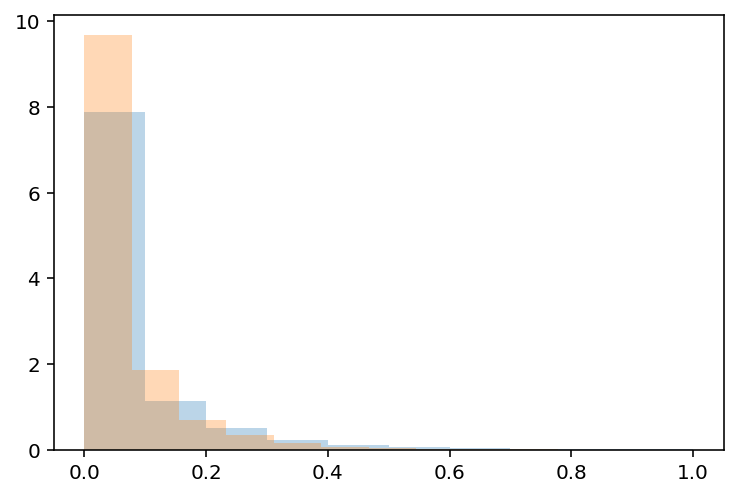

In [138]:
plt.hist(y_train, density= True, alpha= 0.3)
plt.hist(rf.predict(np.array(X_train, dtype=np.float32)), density= True, alpha= 0.3)

In [139]:
metrics.recall_score((rf.predict(np.array(X_val, dtype=np.float32)) >= 0.05).astype(int), (y_val >= 0.05).astype(int))

0.5125270646458397

In [140]:
rf.score(np.array(X_val, dtype=np.float32), y_val)

0.256198962045349

In [141]:
clim_fire_df['pred_freq']= np.zeros(len(clim_fire_df))

clim_fire_df.loc[X_train.index, 'pred_freq']= rf.predict(np.array(X_train, dtype=np.float32))
clim_fire_df.loc[X_val.index, 'pred_freq']= rf.predict(np.array(X_val, dtype=np.float32))

In [142]:
pred_freq_xarr= xarray.DataArray(data= clim_fire_df['pred_freq'].to_numpy().reshape(208, 155),
        dims=["Y", "X"],
        coords=dict(
            X=(["X"], np.linspace(-2349250, -501250, 155)),
            Y=(["Y"], np.linspace(3166500, 682500, 208)),),)

pred_freq_xarr.to_netcdf('../sav_files/pred_freq_prob.nc', mode='w')

### Sanity check

In [5]:
final_month= 432
tot_months= final_month #- start_month
n_regions= 18

#month_arr= np.linspace(start_month, final_month - 1, tot_months, dtype= np.int64)
month_arr= np.linspace(0, final_month - 1, tot_months, dtype= np.int64)
year_arr= np.arange(1984, 2021, 4) #np.asarray([2006, 2009, 2012, 2015, 2018, 2021]) #np.asarray([2015, 2016, 2017, 2018, 2019, 2020])
yr_arr= np.arange(0, tot_months + 1, 12) 

reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", \
          15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}
ind_grid_1= [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
ind_grid_2= [[10, 11, 12], [13, 14, 16]]

In [40]:
tmparr= np.random.choice(np.nonzero(freq_arr[6])[0], (np.sum(freq_arr[6])*(np.std(reg_freq_groups.get_group(1)['obs_freq'])/np.std(pred_freq))).astype(int))

In [41]:
X_test_df.groupby('reg_indx').get_group(1).groupby('month').get_group(m).drop(columns= ['reg_indx', 'month']).index.to_numpy()[tmparr]

array([3746133, 3741808, 3750194, 3741511, 3748828, 3749649, 3742959])

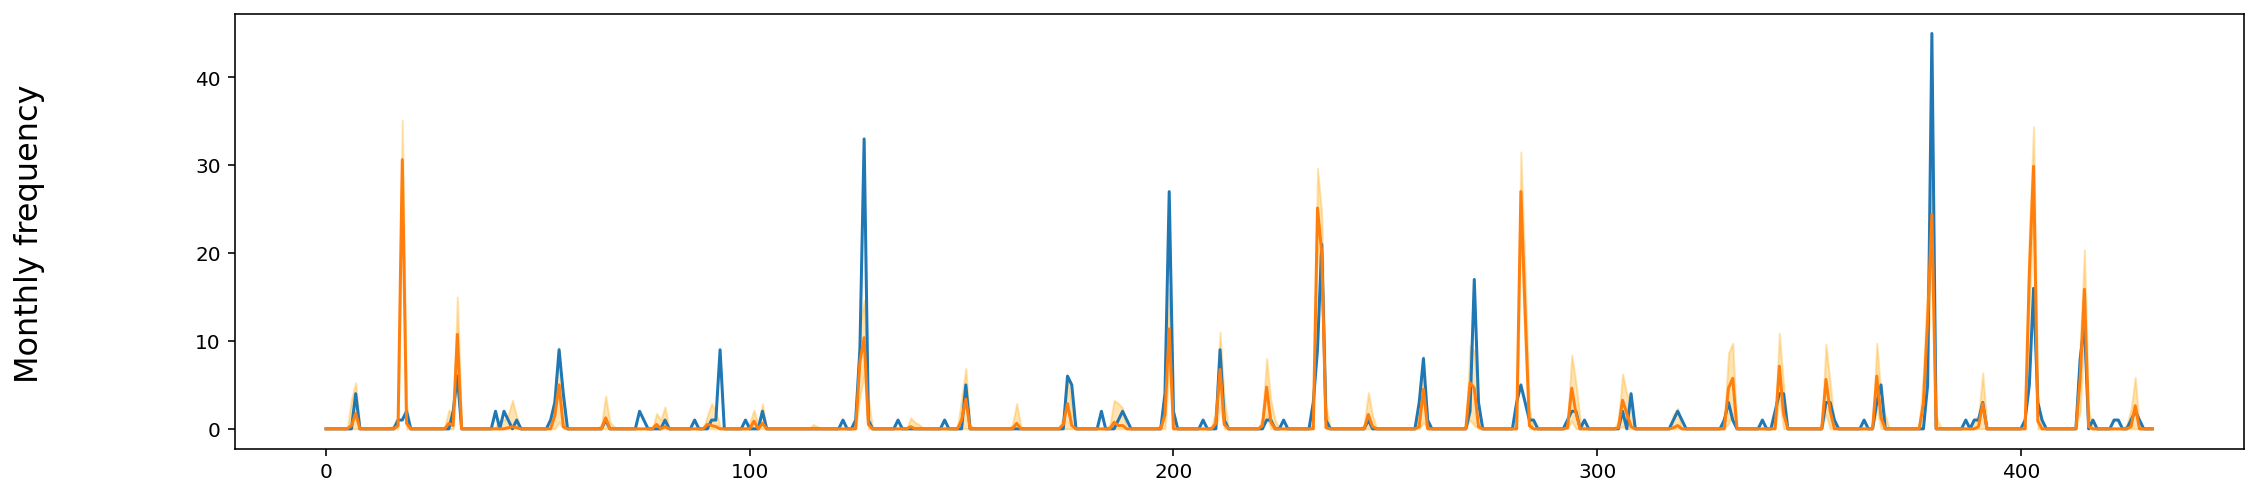

In [17]:
fig, ax= plt.subplots(1, 1, figsize=(18, 4))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
regindx= 7

plt.plot(month_arr, mdn_freq_groups.get_group(regindx)['obs_freq'])
plt.plot(month_arr, mdn_freq_groups.get_group(regindx)['pred_mean_freq']*rfac_arr[0]); #regindx - 1
plt.fill_between(month_arr, mdn_freq_groups.get_group(regindx)['pred_high_2sig']*rfac_arr[0], mdn_freq_groups.get_group(regindx)['pred_low_2sig']*rfac_arr[0], color= 'orange', alpha= 0.3)

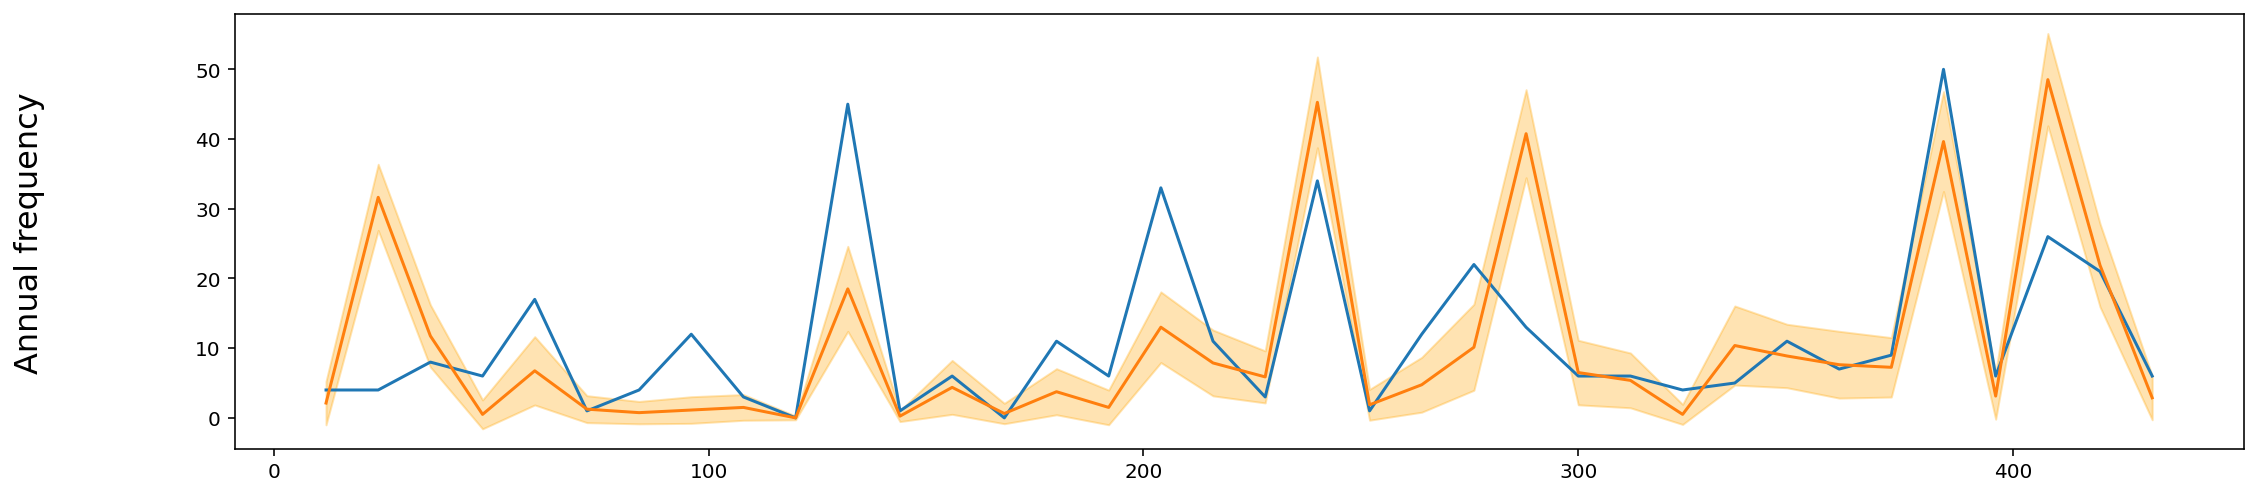

In [19]:
fig, ax= plt.subplots(1, 1, figsize=(18, 4))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Annual frequency', va='center', rotation='vertical', fontsize= 16);
regindx= 7

pred_std= np.asarray([np.sqrt(np.sum((((mdn_freq_groups.get_group(regindx)['pred_high_2sig'] - \
                    mdn_freq_groups.get_group(regindx)['pred_low_2sig'])*rfac_arr[0]/4)**2)[yr_arr[t]:yr_arr[t+1]])) for t in range(len(yr_arr) - 1)])  
pred_freq= np.array([np.sum(mdn_freq_groups.get_group(regindx)['pred_mean_freq'][yr_arr[t]:yr_arr[t+1]])*rfac_arr[0] for t in range(len(yr_arr) - 1)])

plt.plot(yr_arr[1:], np.array([np.sum(mdn_freq_groups.get_group(regindx)['obs_freq'][yr_arr[t]:yr_arr[t+1]]) for t in range(len(yr_arr) - 1)]));
plt.plot(yr_arr[1:], pred_freq);
plt.fill_between(yr_arr[1:], pred_freq + 2*pred_std, pred_freq - 2*pred_std, color= 'orange', alpha= 0.3)

## Random forest (RF) model

### Downsampled model training and prediction

In [37]:
X_train_df= pd.DataFrame([])
rb_frac= 7/3 #fraction of no fires to fires

df1= fire_freq_train_df[fire_freq_train_df['fire_freq']==1]
n2= rb_frac*len(df1)
df2= fire_freq_train_df[fire_freq_train_df['fire_freq']==0]
df2= df2.sample(n= int(n2))
df_r= pd.concat([df1, df2], sort= False).sample(frac= 1).reset_index(drop=True) #shuffling the rows

y_r = np.array(df_r.fire_freq, dtype=np.float32)
X_r = df_r.iloc[:, 0:36].drop(columns= ['Solar', 'Ant_Tmax','RH', 'Ant_RH']) #'solar', 'prec', 'deltaT', 'tmin','wind','forest','urban'
scaler= StandardScaler().fit(X_r)
#X_r= scaler.transform(X_r)
X_train_df[X_r.columns]= scaler.transform(X_r)
#X_r= np.array(X_r, dtype=np.float32)

X_train, X_val, y_train, y_val = train_test_split(X_train_df, y_r, test_size=0.3, random_state= 99)

In [38]:
y= np.array(fire_freq_test_df.fire_freq)
X= fire_freq_test_df.iloc[:, 0:36].drop(columns= ['Solar', 'Ant_Tmax','RH', 'Ant_RH'])
X_test= scaler.transform(X)

In [39]:
X_df= pd.DataFrame([])
X_df[X.columns]= scaler.fit_transform(X)
X_df['reg_indx']= fire_freq_test_df.reg_indx
X_df['month']= fire_freq_test_df.month

### Calibrating RF hyperparameters

In [18]:
#run_id= '22_02_07'
#param_df= rf_hyperparam_tuning(clim_df, n_iters= 5, run_id= run_id)
#param_df.to_hdf('../sav_files/rf_runs_%s'%run_id + '/rf_params_%s.h5'%run_id, key= 'df', mode= 'w')

In [4]:
run_id= '22_02_07'
param_df= pd.read_hdf('../sav_files/rf_runs_%s'%run_id + '/rf_params_%s.h5'%run_id)
param_df['tot_metric']= param_df['Test Accuracy']*param_df['Test Recall']

In [5]:
param_df.sort_values(by= ['tot_metric'], ascending= False).fillna(value= 0.0).groupby('Threshold').get_group(0.5).groupby('Trees').get_group(250).head()

,Iteration,Trees,Rebalance frac,Threshold,Train Accuracy,Train Recall,Test Accuracy,Test Recall,tot_metric
136,2,250,2.333333,0.5,0.8470,0.741729,0.813493,0.820091,0.667138
46,1,250,2.333333,0.5,0.8549,0.747784,0.815683,0.817679,0.666967
406,5,250,2.333333,0.5,0.8509,0.745693,0.816855,0.814983,0.665723
316,4,250,2.333333,0.5,0.8457,0.740541,0.820515,0.811010,0.665446
226,3,250,2.333333,0.5,0.8520,0.747268,0.819982,0.808173,0.662687


In [ ]:
# Make two plots as discussed in Roam note

In [ ]:
#%time rf, forest, train_metrics, test_metrics= rf_fire_grid_run(clim_grid_df= clim_df, rb_frac= 7/3, n_features= 36, threshold= None, criterion= 'entropy')

### Variable Importance

In [15]:
pimp_flag= False
feature_list= list(clim_df.iloc[:, 0:20].drop(columns= ['Solar', 'Ant_Tmax', 'RH', 'Ant_RH']).columns)
if not pimp_flag:
    importances= list(forest.feature_importances_)
    feature_importances= [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
else:
    importances= permutation_importance(forest, X, y, n_repeats=10, random_state=42, n_jobs= -1)
    feature_importances= [(feature, abs(importance)) for feature, importance in zip(feature_list, importances['importances_mean'])]
feature_importances = sorted(feature_importances, key= lambda x: x[1], reverse= True)
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

Variable: FM1000               Importance: 0.0988
Variable: VPD                  Importance: 0.0987
Variable: Tmax                 Importance: 0.0795
Variable: Solar                Importance: 0.0768
Variable: Antprec_lag1         Importance: 0.0694
Variable: Tmin                 Importance: 0.0683
Variable: Prec                 Importance: 0.0501
Variable: Ant_Tmax             Importance: 0.0495
Variable: Forest               Importance: 0.049
Variable: Grassland            Importance: 0.0487
Variable: AvgVPD_3mo           Importance: 0.047
Variable: CAPE                 Importance: 0.0449
Variable: Avgprec_3mo          Importance: 0.0427
Variable: Wind                 Importance: 0.0406
Variable: Elev                 Importance: 0.0401
Variable: FFWI_max3            Importance: 0.034
Variable: FFWI_max7            Importance: 0.0335
Variable: Urban                Importance: 0.0285


Text(0.5, 1.0, 'Variable Importance')

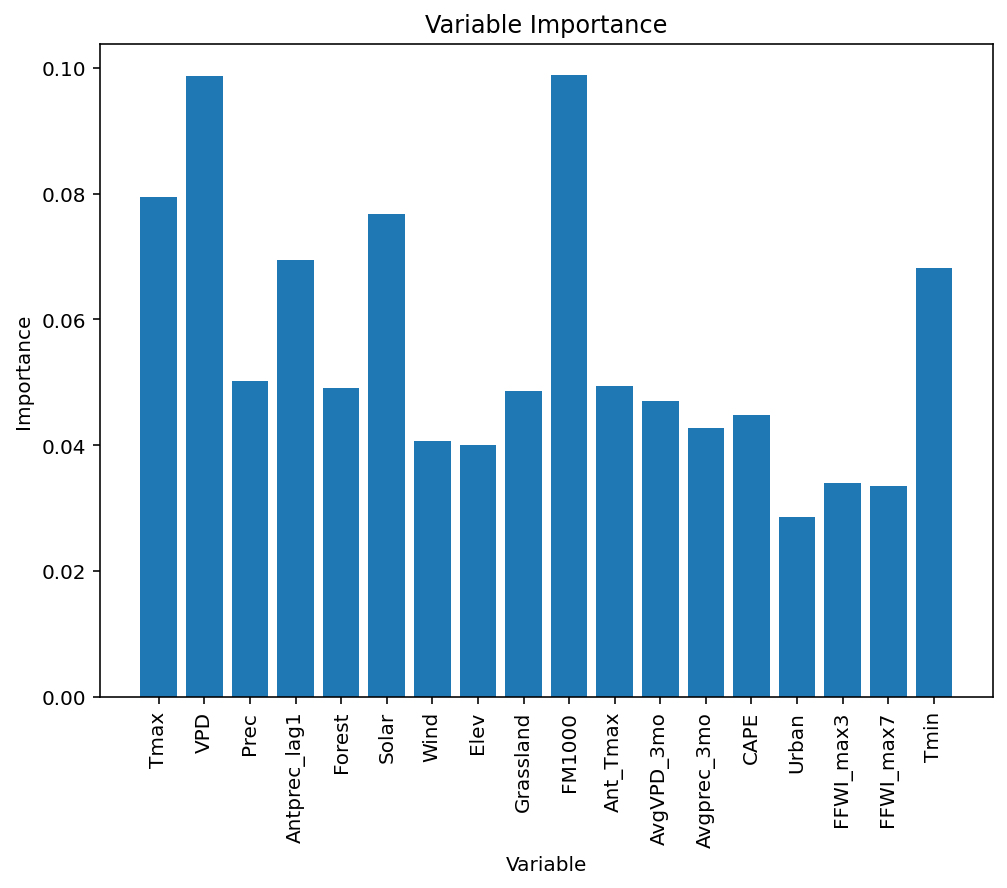

In [16]:
plt.rcParams["figure.figsize"] = (8, 6)
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importance')

### Sanity check

#### Training

In [5]:
# Instantiate model with n_estimators decision trees
rf= RandomForestClassifier(n_estimators= 100, random_state= 42)

In [6]:
# Train the model on training data
%time forest= rf.fit(np.array(X_train, dtype=np.float32), y_train)
#joblib.dump(rf, "../sav_files/rf_mod_full_100.joblib")

CPU times: user 1h 2min 38s, sys: 13.7 s, total: 1h 2min 52s
Wall time: 1h 2min 53s


#### Testing on validation set

In [7]:
# Use the forest's predict method on the test data
predictions = rf.predict(np.array(X_val, dtype=np.float32))
# Calculate the absolute errors
errors = abs(predictions - y_val)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 6), 'degrees.')

Mean Absolute Error: 0.001667 degrees.


In [8]:
pscore = metrics.accuracy_score(y_val, predictions)
print("accuracy: ", pscore)
score = metrics.f1_score(y_val, predictions)
print("f1 score: ", score)
recall = metrics.recall_score(y_val, predictions)
print("recall: ", recall)

accuracy:  0.9983332119378613
f1 score:  0.0
recall:  0.0


In [9]:
cf = confusion_matrix(y_val, predictions)
cf

array([[1768119,       0],
       [   2952,       0]])

In [166]:
threshold= 0.5
predicted_thresh= rf.predict_proba(X_val)
predicted_thresh= (predicted_thresh[:, 1] >= threshold).astype('int')

In [167]:
pscore = metrics.accuracy_score(y_val, predicted_thresh)
print("accuracy: ", pscore)
score = metrics.f1_score(y_val, predicted_thresh)
print("f1 score: ", score)
recall = metrics.recall_score(y_val, predicted_thresh)
print("recall: ", recall)

accuracy:  0.8590976944766959
f1 score:  0.7013534891896643
recall:  0.6581986143187067


In [168]:
cf = confusion_matrix(y_val, predicted_thresh)
cf

array([[8364,  663],
       [1036, 1995]])

#### Testing on real dataset

In [170]:
%time predictions= rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 6), 'degrees.')

CPU times: user 1min 25s, sys: 3.95 s, total: 1min 29s
Wall time: 1min 32s
Mean Absolute Error: 0.140759 degrees.


In [171]:
pscore = metrics.accuracy_score(y, predictions)
print("accuracy: ", pscore)
score = metrics.f1_score(y, predictions)
print("f1 score: ", score)
recall = metrics.recall_score(y, predictions)
print("recall: ", recall)

accuracy:  0.859241442753651
f1 score:  0.018523192967868383
recall:  0.7607867052904406


In [81]:
cf = confusion_matrix(y, predictions)
cf

array([[9590257,  718791],
       [   6294,   10754]])

In [172]:
threshold= 0.5
%time predicted_thresh= rf.predict_proba(X)
predicted_thresh= (predicted_thresh[:, 1] >= threshold).astype('int')

CPU times: user 1min 28s, sys: 2.85 s, total: 1min 31s
Wall time: 1min 37s


In [173]:
pscore = metrics.accuracy_score(y, predicted_thresh)
print("accuracy: ", pscore)
score = metrics.f1_score(y, predicted_thresh)
print("f1 score: ", score)
recall = metrics.recall_score(y, predicted_thresh)
print("recall: ", recall)

accuracy:  0.8569770252256166
f1 score:  0.018321369388989272
recall:  0.764445799664583


In [91]:
cf = confusion_matrix(y, predicted_thresh)
cf

array([[8808548, 1500500],
       [   2911,   14137]])

### Predicting regional monthly fire frequencies 

In [34]:
loaded_rf = joblib.load("../sav_files/rf_mod_full_100.joblib")

In [39]:
reg_predictions= []
for m in tqdm(np.linspace(start_month, final_month - 1, tot_months, dtype= np.int64)):
    X_arr= np.array(X_df.groupby('reg_indx').get_group(1).groupby('month').get_group(m).drop(columns= ['reg_indx', 'month']), dtype= np.float32)
    reg_predictions.append(loaded_rf.predict_proba(X_arr)[:, 1])

100%|█████████████████████████████████████████| 168/168 [00:17<00:00,  9.79it/s]


In [37]:
np.mean([np.mean(reg_predictions[i][reg_predictions[i] > 0]) for i in range(tot_months)])

0.013306330173909496

In [23]:
grid_freq= []
pred_freq= []
for m in tqdm(np.linspace(start_month, final_month - 1, tot_months, dtype= np.int64)):
    X_arr= np.array(X_df.groupby('reg_indx').get_group(1).groupby('month').get_group(m).drop(columns= ['reg_indx', 'month']), dtype= np.float32)
    param_vec= mdn.predict(x= tf.constant(X_arr))
    freq_samp= zipd_model(param_vec).sample(10000, seed= 99)
    grid_freq.append(tf.cast(tf.reduce_mean(freq_samp, axis= 0), tf.int64).numpy())
    pred_freq.append(tf.reduce_sum(tf.cast(tf.reduce_mean(freq_samp, axis= 0), tf.int64)).numpy())

100%|█████████████████████████████████████████| 168/168 [00:33<00:00,  5.07it/s]


In [43]:
tf.reduce_mean(tf.reduce_sum(tf.random.categorical(tf.math.log(list(zip(1 -  reg_predictions[8]*grid_freq[8],  reg_predictions[8]*grid_freq[8]))), 1000), \
                                                                                                                                                     axis= 0))

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [184]:
reg_freq_df= pd.DataFrame([])

for r in tqdm(range(n_regions)):
    reg_predictions= []
    for i in np.linspace(start_month, final_month - 1, tot_months, dtype= np.int64):
        X_arr= np.array(X_df.groupby('reg_indx').get_group(r+1).groupby('month').get_group(i).drop(columns= ['reg_indx', 'month']), dtype= np.float32)
        reg_predictions.append(rf.predict_proba(X_arr)[:, 1])
    
    obs_freqs= [np.sum(fire_freq_test_df.groupby('reg_indx').get_group(r+1).groupby('month').get_group(m).fire_freq) \
                                                                          for m in np.linspace(start_month, final_month - 1, tot_months, dtype= np.int64)]
    pred_freqs= [tf.reduce_mean(tf.reduce_sum(tf.random.categorical(tf.math.log(list(zip(1 - reg_predictions[m], reg_predictions[m]))), 1000), axis= 0)).numpy() \
                                                                                                                    for m in range(tot_months)]
    reg_indx_arr= np.ones(tot_months, dtype= np.int64)*(r+1)
    reg_freq_df= reg_freq_df.append(pd.DataFrame({'obs_freq': obs_freqs, 'pred_freq': pred_freqs, 'reg_indx': reg_indx_arr}))

100%|██████████| 18/18 [24:49<00:00, 82.75s/it]


In [185]:
reg_freq_groups= reg_freq_df.groupby('reg_indx')

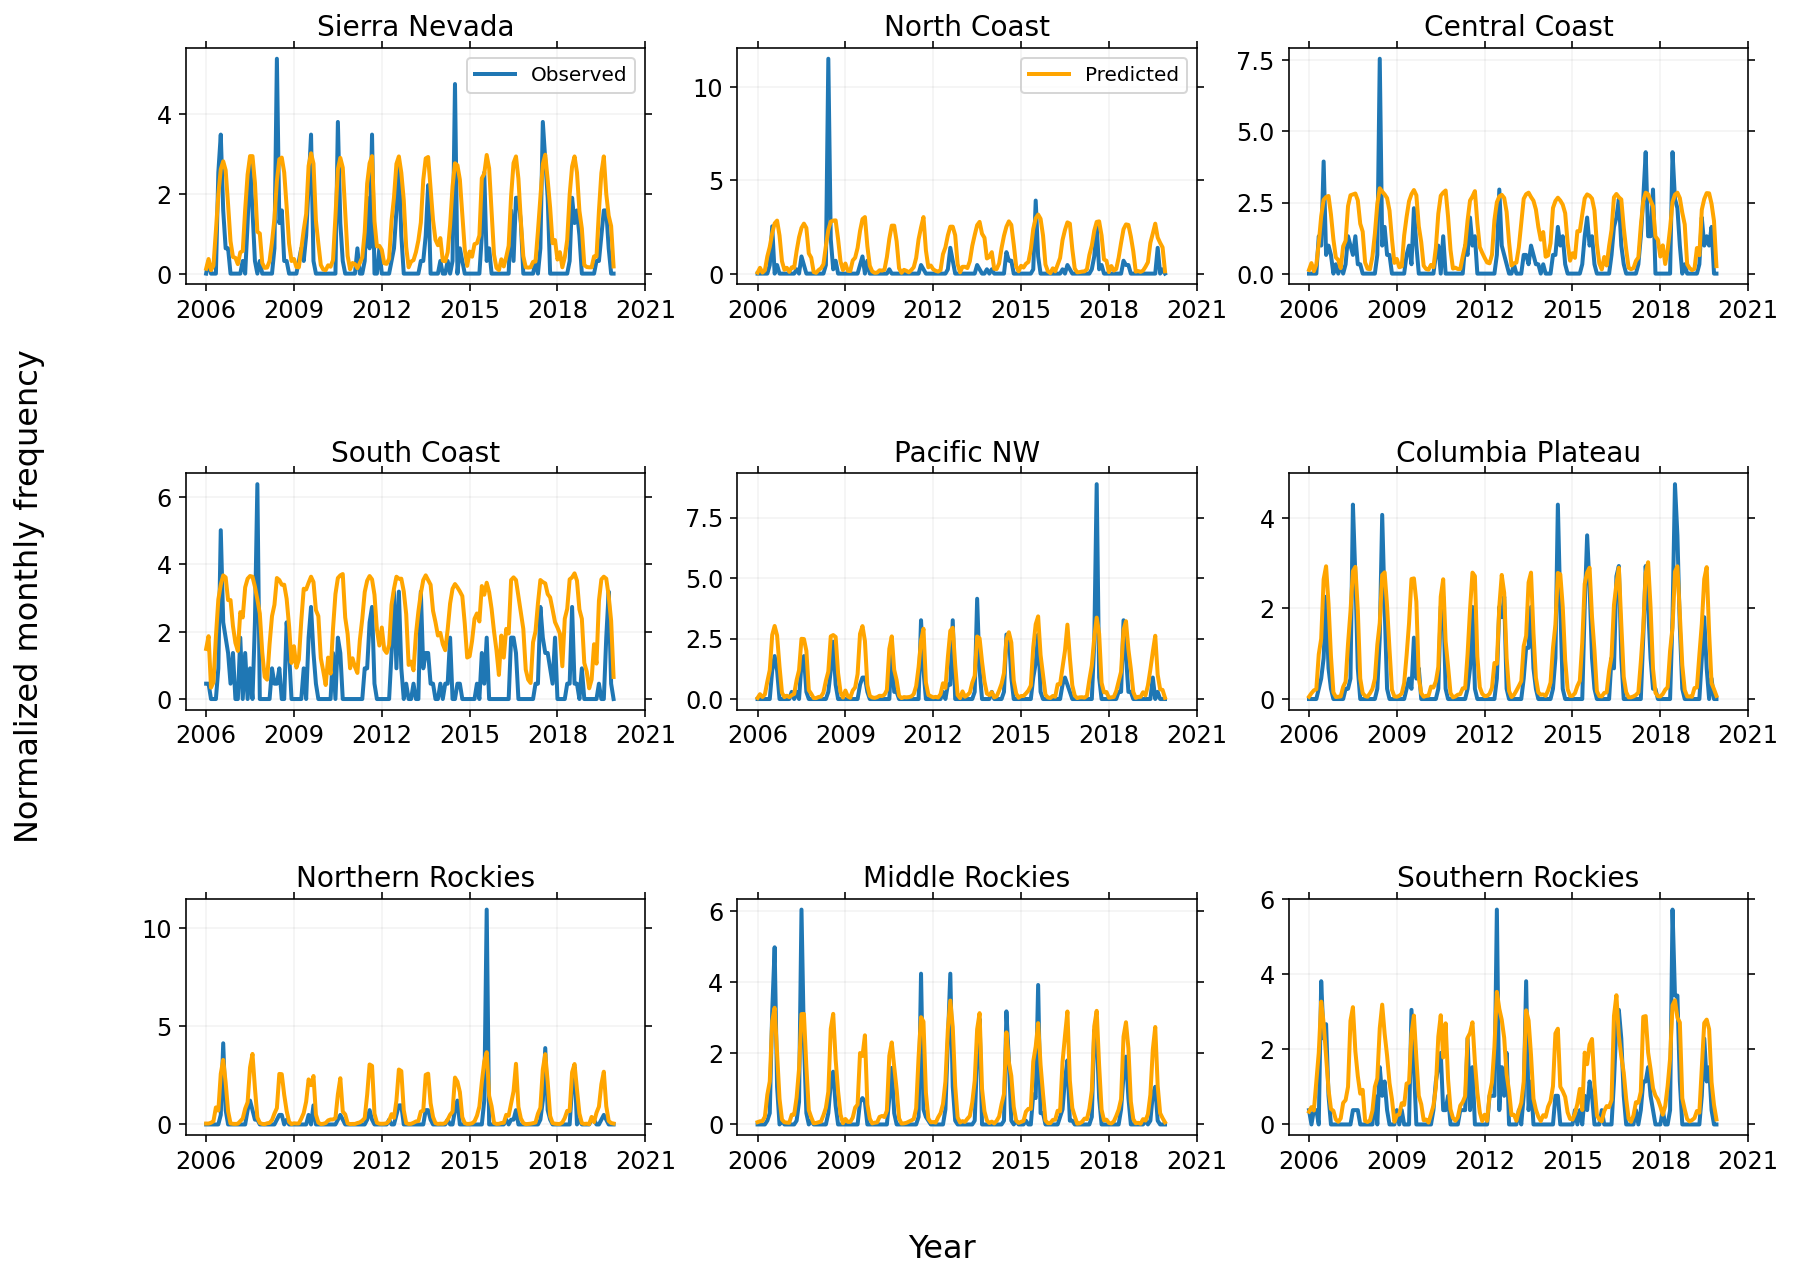

In [215]:
fig, ax= plt.subplots(3, 3, figsize=(14, 10))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Normalized monthly frequency', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(3):
    for j in range(3):
        regindx= ind_grid_1[i][j]
        if i+j == 0:
            ax[i, j].plot(month_arr, (reg_freq_groups.get_group(regindx)['obs_freq'])/np.std(reg_freq_groups.get_group(regindx)['obs_freq']), lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, (reg_freq_groups.get_group(regindx)['obs_freq'])/np.std(reg_freq_groups.get_group(regindx)['obs_freq']), lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(month_arr, (reg_freq_groups.get_group(regindx)['pred_freq'])/np.std(reg_freq_groups.get_group(regindx)['pred_freq']), color= 'orange', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, (reg_freq_groups.get_group(regindx)['pred_freq'])/np.std(reg_freq_groups.get_group(regindx)['pred_freq']), color= 'orange', lw= 2);
        
        ax[i, j].set_title(reg_name[regindx], fontsize= 14);
        ax[i, j].set_xticks((year_arr - 2006)*12 + start_month);
        ax[i, j].set_xticklabels(year_arr)
            
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

#plt.savefig('../plots/rf_norm_fire_freq_1.pdf', bbox_inches='tight');

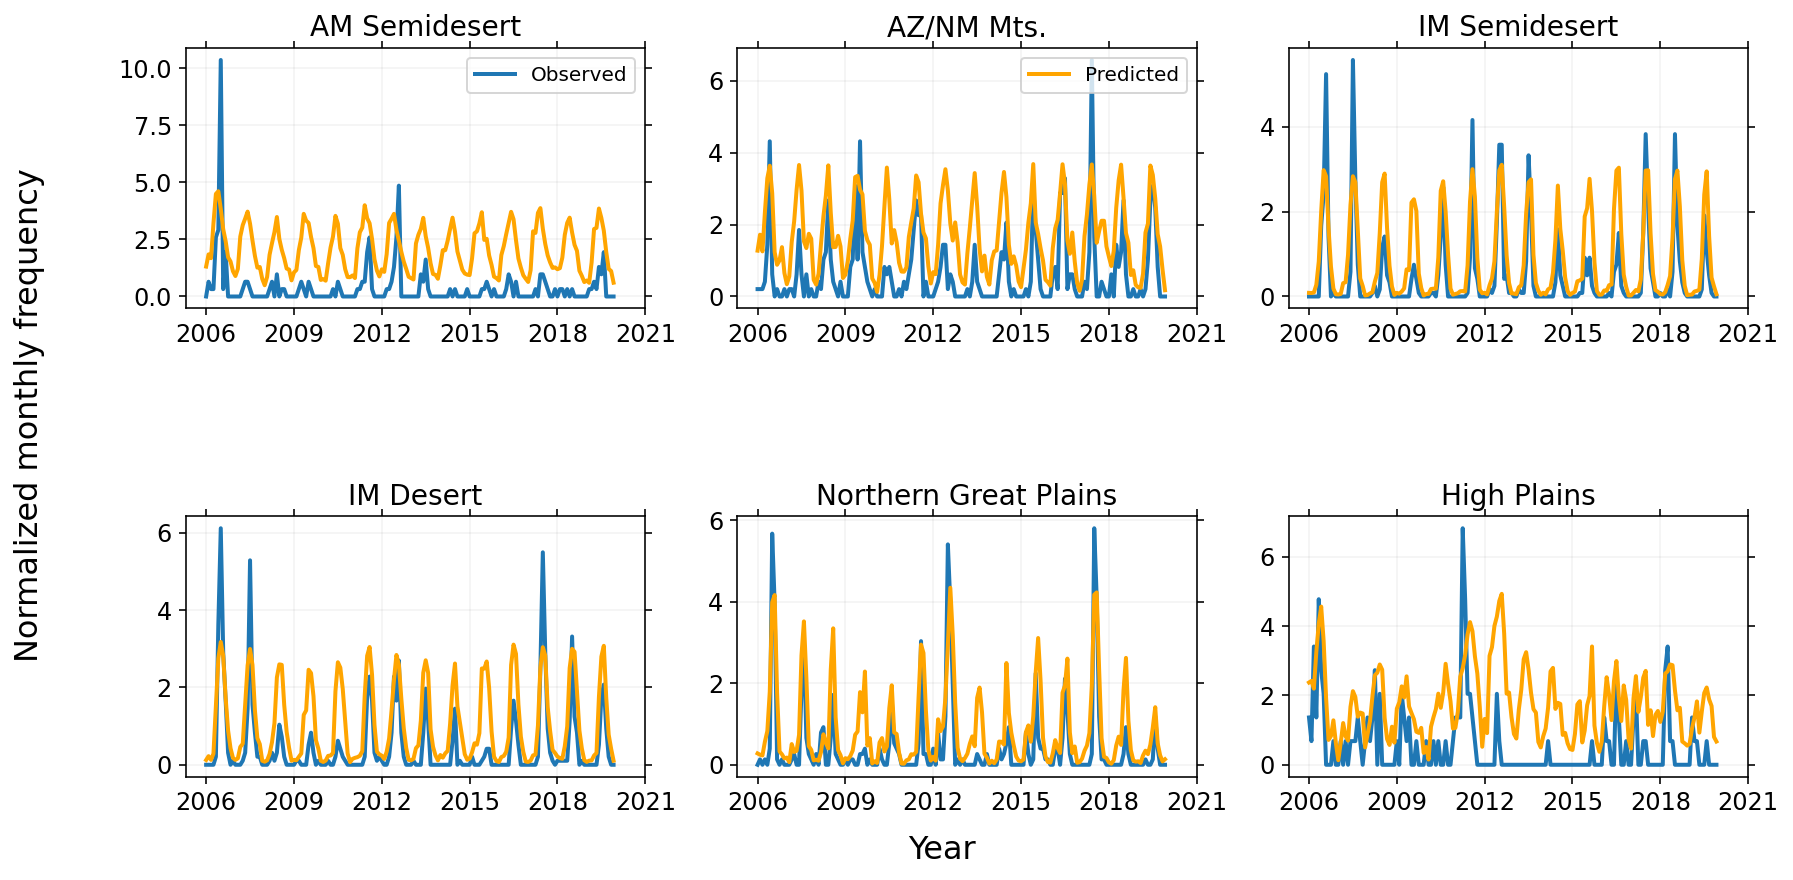

In [214]:
fig, ax= plt.subplots(2, 3, figsize=(14, 6.7))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Normalized monthly frequency', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(2):
    for j in range(3):
        regindx= ind_grid_2[i][j]
        if i+j == 0:
            ax[i, j].plot(month_arr, (reg_freq_groups.get_group(regindx)['obs_freq'])/np.std(reg_freq_groups.get_group(regindx)['obs_freq']), lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, (reg_freq_groups.get_group(regindx)['obs_freq'])/np.std(reg_freq_groups.get_group(regindx)['obs_freq']), lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(month_arr, (reg_freq_groups.get_group(regindx)['pred_freq'])/np.std(reg_freq_groups.get_group(regindx)['pred_freq']), color= 'orange', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, (reg_freq_groups.get_group(regindx)['pred_freq'])/np.std(reg_freq_groups.get_group(regindx)['pred_freq']), color= 'orange', lw= 2);
        
        ax[i, j].set_title(reg_name[regindx], fontsize= 14);
        ax[i, j].set_xticks((year_arr - 2006)*12 + start_month);
        ax[i, j].set_xticklabels(year_arr)
            
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

#plt.savefig('../plots/rf_norm_fire_freq_2.pdf', bbox_inches='tight');

In [377]:
#reg_freq_df.to_hdf('../sav_files/rf_mon_freq_df.h5', key= 'df', mode= 'w')